In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.data import AUTOTUNE
import sentiment


DATASET_DIR = './goemotions/data-v2/'

In [2]:
classes = sentiment.load_classes(DATASET_DIR)
classes

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

Random seed: 1681939068


D:\sentiment-analysis\sentiment.py:286: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  class_mask = (train_df['labels'].str.contains(r'(^|,)' + label +
D:\sentiment-analysis\sentiment.py:613: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes, rotation=45, ha='right')


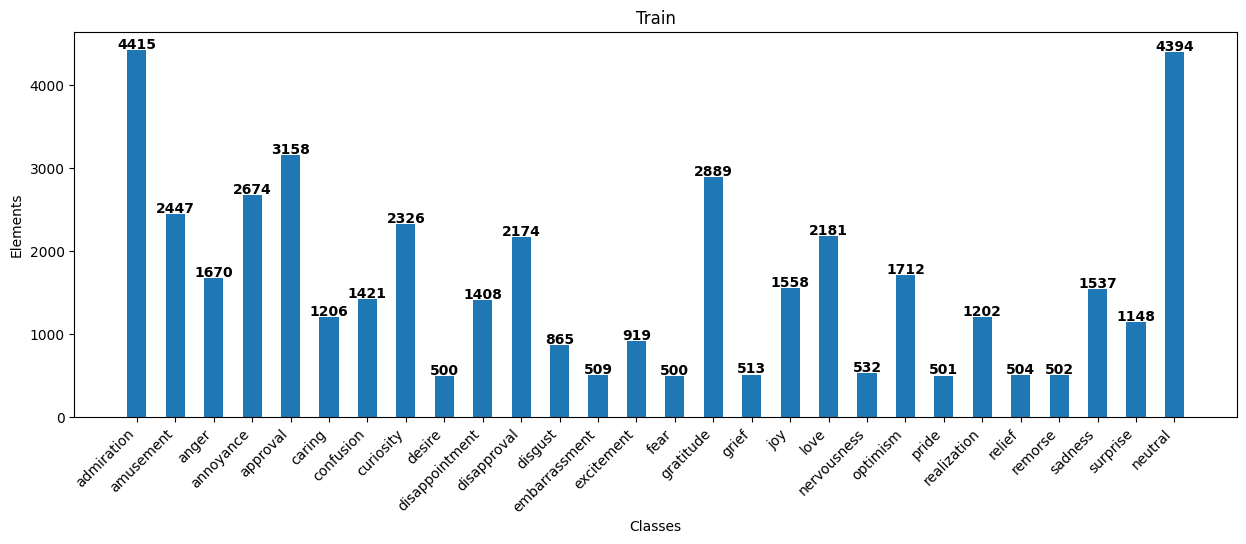

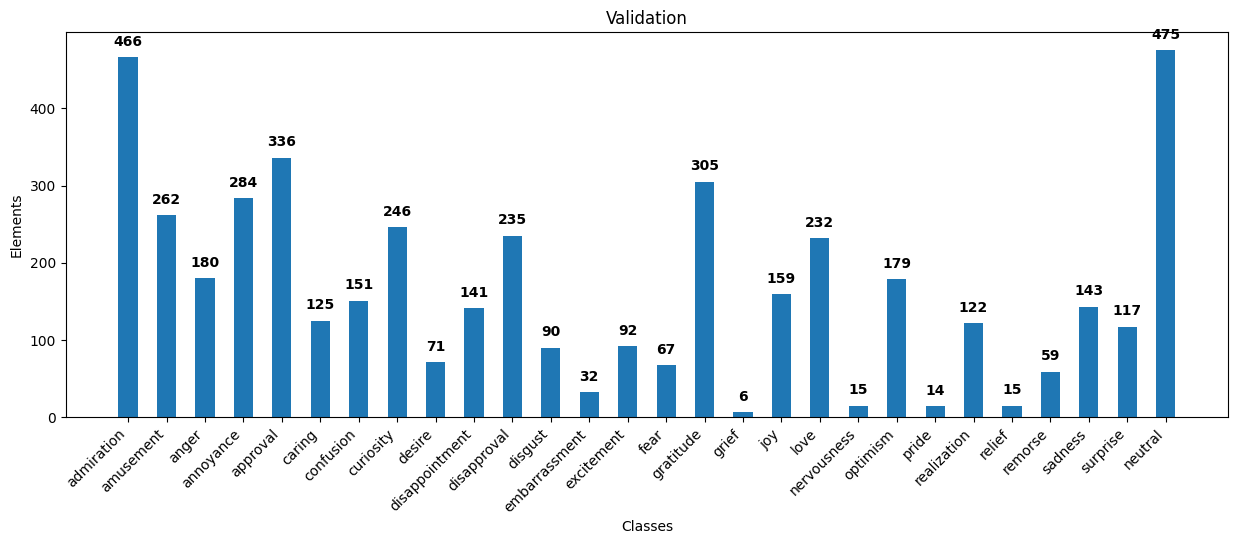

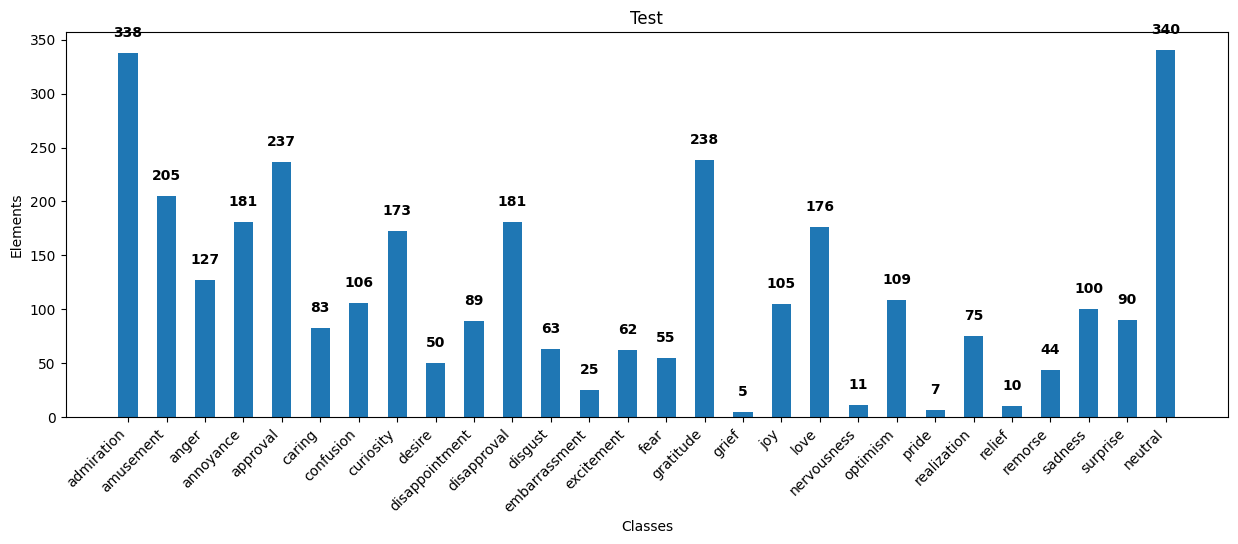

CPU times: total: 7.62 s
Wall time: 7.71 s


In [3]:
%%time
BATCH_SIZE = 64


train_df, val_df, test_df = sentiment.make_dataframes(DATASET_DIR,
                                                      fraction=0.9,
                                                      split_by_class=True,
                                                      clean=True,
                                                      cut_neutral=True,
                                                      test_only_singles=True,
                                                      oversample_low=True,
                                                      low_threshold=500)
dataframes = {'Train': train_df, 'Validation': val_df, 'Test': test_df}
for title, df in dataframes.items():
    sentiment.plot_class_distr(df, classes, title)

In [4]:
train_ds = sentiment.make_ts_ds(train_df, classes, BATCH_SIZE, AUTOTUNE)
val_ds = sentiment.make_ts_ds(val_df, classes, BATCH_SIZE, AUTOTUNE)
test_ds = sentiment.make_ts_ds(test_df, classes, BATCH_SIZE, AUTOTUNE)

In [5]:
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 30_000


encoder = TextVectorization(max_tokens=VOCAB_SIZE,
                            standardize='lower_and_strip_punctuation',
                            split='whitespace',
                            pad_to_max_tokens=True,
                            ngrams=(1, 2),
                            output_mode='tf_idf')
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['[UNK]', 'i', 'the', 'is', 'to', 'a', 'you', 'it', 'that', 'and',
       'not', 'of', 'this', 'for', 'in', 'are', 'have', 'am', 'was', 'my'],
      dtype='<U25')

In [6]:
from tensorflow.keras.layers import (Dropout, Dense)
from tensorflow.keras import Sequential, regularizers

classifier = Sequential([
    encoder,
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(classes), activation='sigmoid'),
])

In [7]:
from tensorflow.keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

METRICS_THRESHOLD = 0.5
LEARNING_RATE = 1e-4


metrics = sentiment.create_metrics(classes, METRICS_THRESHOLD)
loss = BinaryCrossentropy()
classifier.compile(Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=metrics)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 200


hist = classifier.fit(x=train_ds, validation_data=val_ds,
                      validation_steps=30, epochs=EPOCHS,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
                      # class_weight=class_weights
                     )

Epoch 1/200
561/561 [==============================] - 46s 72ms/step - loss: 0.2877 - precision@0.5/admiration: 0.1286 - recall@0.5/admiration: 0.1026 - precision@0.5/amusement: 0.0787 - recall@0.5/amusement: 0.0225 - precision@0.5/anger: 0.0366 - recall@0.5/anger: 0.0228 - precision@0.5/annoyance: 0.0890 - recall@0.5/annoyance: 0.0146 - precision@0.5/approval: 0.0952 - recall@0.5/approval: 0.1238 - precision@0.5/caring: 0.0541 - recall@0.5/caring: 0.0017 - precision@0.5/confusion: 0.0251 - recall@0.5/confusion: 0.0063 - precision@0.5/curiosity: 0.0670 - recall@0.5/curiosity: 0.1427 - precision@0.5/desire: 0.0244 - recall@0.5/desire: 0.0040 - precision@0.5/disappointment: 0.0436 - recall@0.5/disappointment: 0.0589 - precision@0.5/disapproval: 0.0492 - recall@0.5/disapproval: 0.0060 - precision@0.5/disgust: 0.0000e+00 - recall@0.5/disgust: 0.0000e+00 - precision@0.5/embarrassment: 0.0729 - recall@0.5/embarrassment: 0.0138 - precision@0.5/excitement: 0.0259 - recall@0.5/excitement: 0.082

In [9]:
eval_metrics = classifier.evaluate(x=test_ds, return_dict=True)
sentiment.print_metrics(eval_metrics)

52/52 [==============================] - 1s 16ms/step - loss: 0.1018 - precision@0.5/admiration: 0.6842 - recall@0.5/admiration: 0.6154 - precision@0.5/amusement: 0.7772 - recall@0.5/amusement: 0.7659 - precision@0.5/anger: 0.5862 - recall@0.5/anger: 0.4016 - precision@0.5/annoyance: 0.2339 - recall@0.5/annoyance: 0.1602 - precision@0.5/approval: 0.4554 - recall@0.5/approval: 0.2152 - precision@0.5/caring: 0.5094 - recall@0.5/caring: 0.3253 - precision@0.5/confusion: 0.5000 - recall@0.5/confusion: 0.3113 - precision@0.5/curiosity: 0.5039 - recall@0.5/curiosity: 0.3757 - precision@0.5/desire: 0.8824 - recall@0.5/desire: 0.3000 - precision@0.5/disappointment: 0.2692 - recall@0.5/disappointment: 0.0787 - precision@0.5/disapproval: 0.5000 - recall@0.5/disapproval: 0.2541 - precision@0.5/disgust: 0.5667 - recall@0.5/disgust: 0.2698 - precision@0.5/embarrassment: 0.8000 - recall@0.5/embarrassment: 0.1600 - precision@0.5/excitement: 0.6296 - recall@0.5/excitement: 0.2742 - precision@0.5/fear:

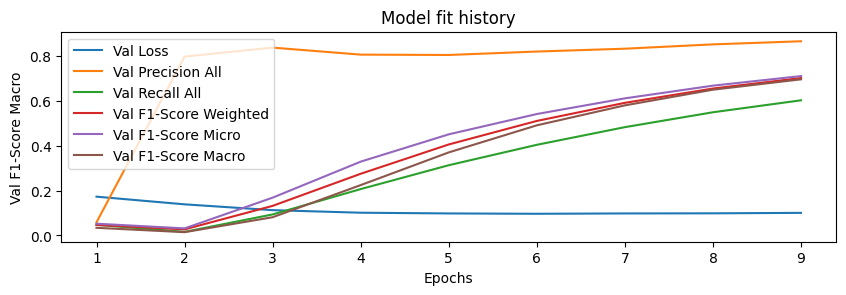

In [10]:
stats = hist.history
stats_graps = {
    'Val Loss': stats['val_loss'],
    'Val Precision All': stats['precision@0.5/all'],
    'Val Recall All': stats['recall@0.5/all'],
    'Val F1-Score Weighted': stats['f1_score@0.5/all'],
    'Val F1-Score Micro': stats['f1_score_micro@0.5/all'],
    'Val F1-Score Macro': stats['f1_score_macro@0.5/all'],
}
sentiment.plot_history(stats_graps)

In [11]:
sentiment.calc_TP_perc(test_ds, classifier)

0.4121765601217656

In [12]:
sentiments = sentiment.load_sentiments(DATASET_DIR)
sentiment_map = sentiment.map_sentiments(classes, sentiments)
sentiment.calc_TP_perc(test_ds, classifier, sentiment_map)

0.4992389649923896

In [13]:
sentiment.test_examples(classifier, classes)

I am feeling great today!: admiration 👏
The weather is so good: admiration 👏
WARNING! Model not sure (all predictions less than 0.5)
I have performed well at the university: realization 💡
The war has started: neutral ⚪
WARNING! Model not sure (all predictions less than 0.5)
He is desperate in this cruel world: anger 😡
I love the feeling when my girlfriend hugs me: love ❤️
I hate monday mornings: anger 😡
Look forward to seeing you today: approval 👍
WARNING! Model not sure (all predictions less than 0.5)
Merry Christmas! I told Santa you were good this year and asked him to bring you a year full of joy and pleasure : admiration 👏
brilliant! Such a detailed review, it was a pleasure, thank you! Guys, make sure you find time to read :) Aaaaand you can actually choose sth new): gratitude 🙏
WARNING! Model not sure (all predictions less than 0.5)
I have the new pan for pancakes.: neutral ⚪
WARNING! Model not sure (all predictions less than 0.5)
I'm wearing a special red ribbon for luck.: grat

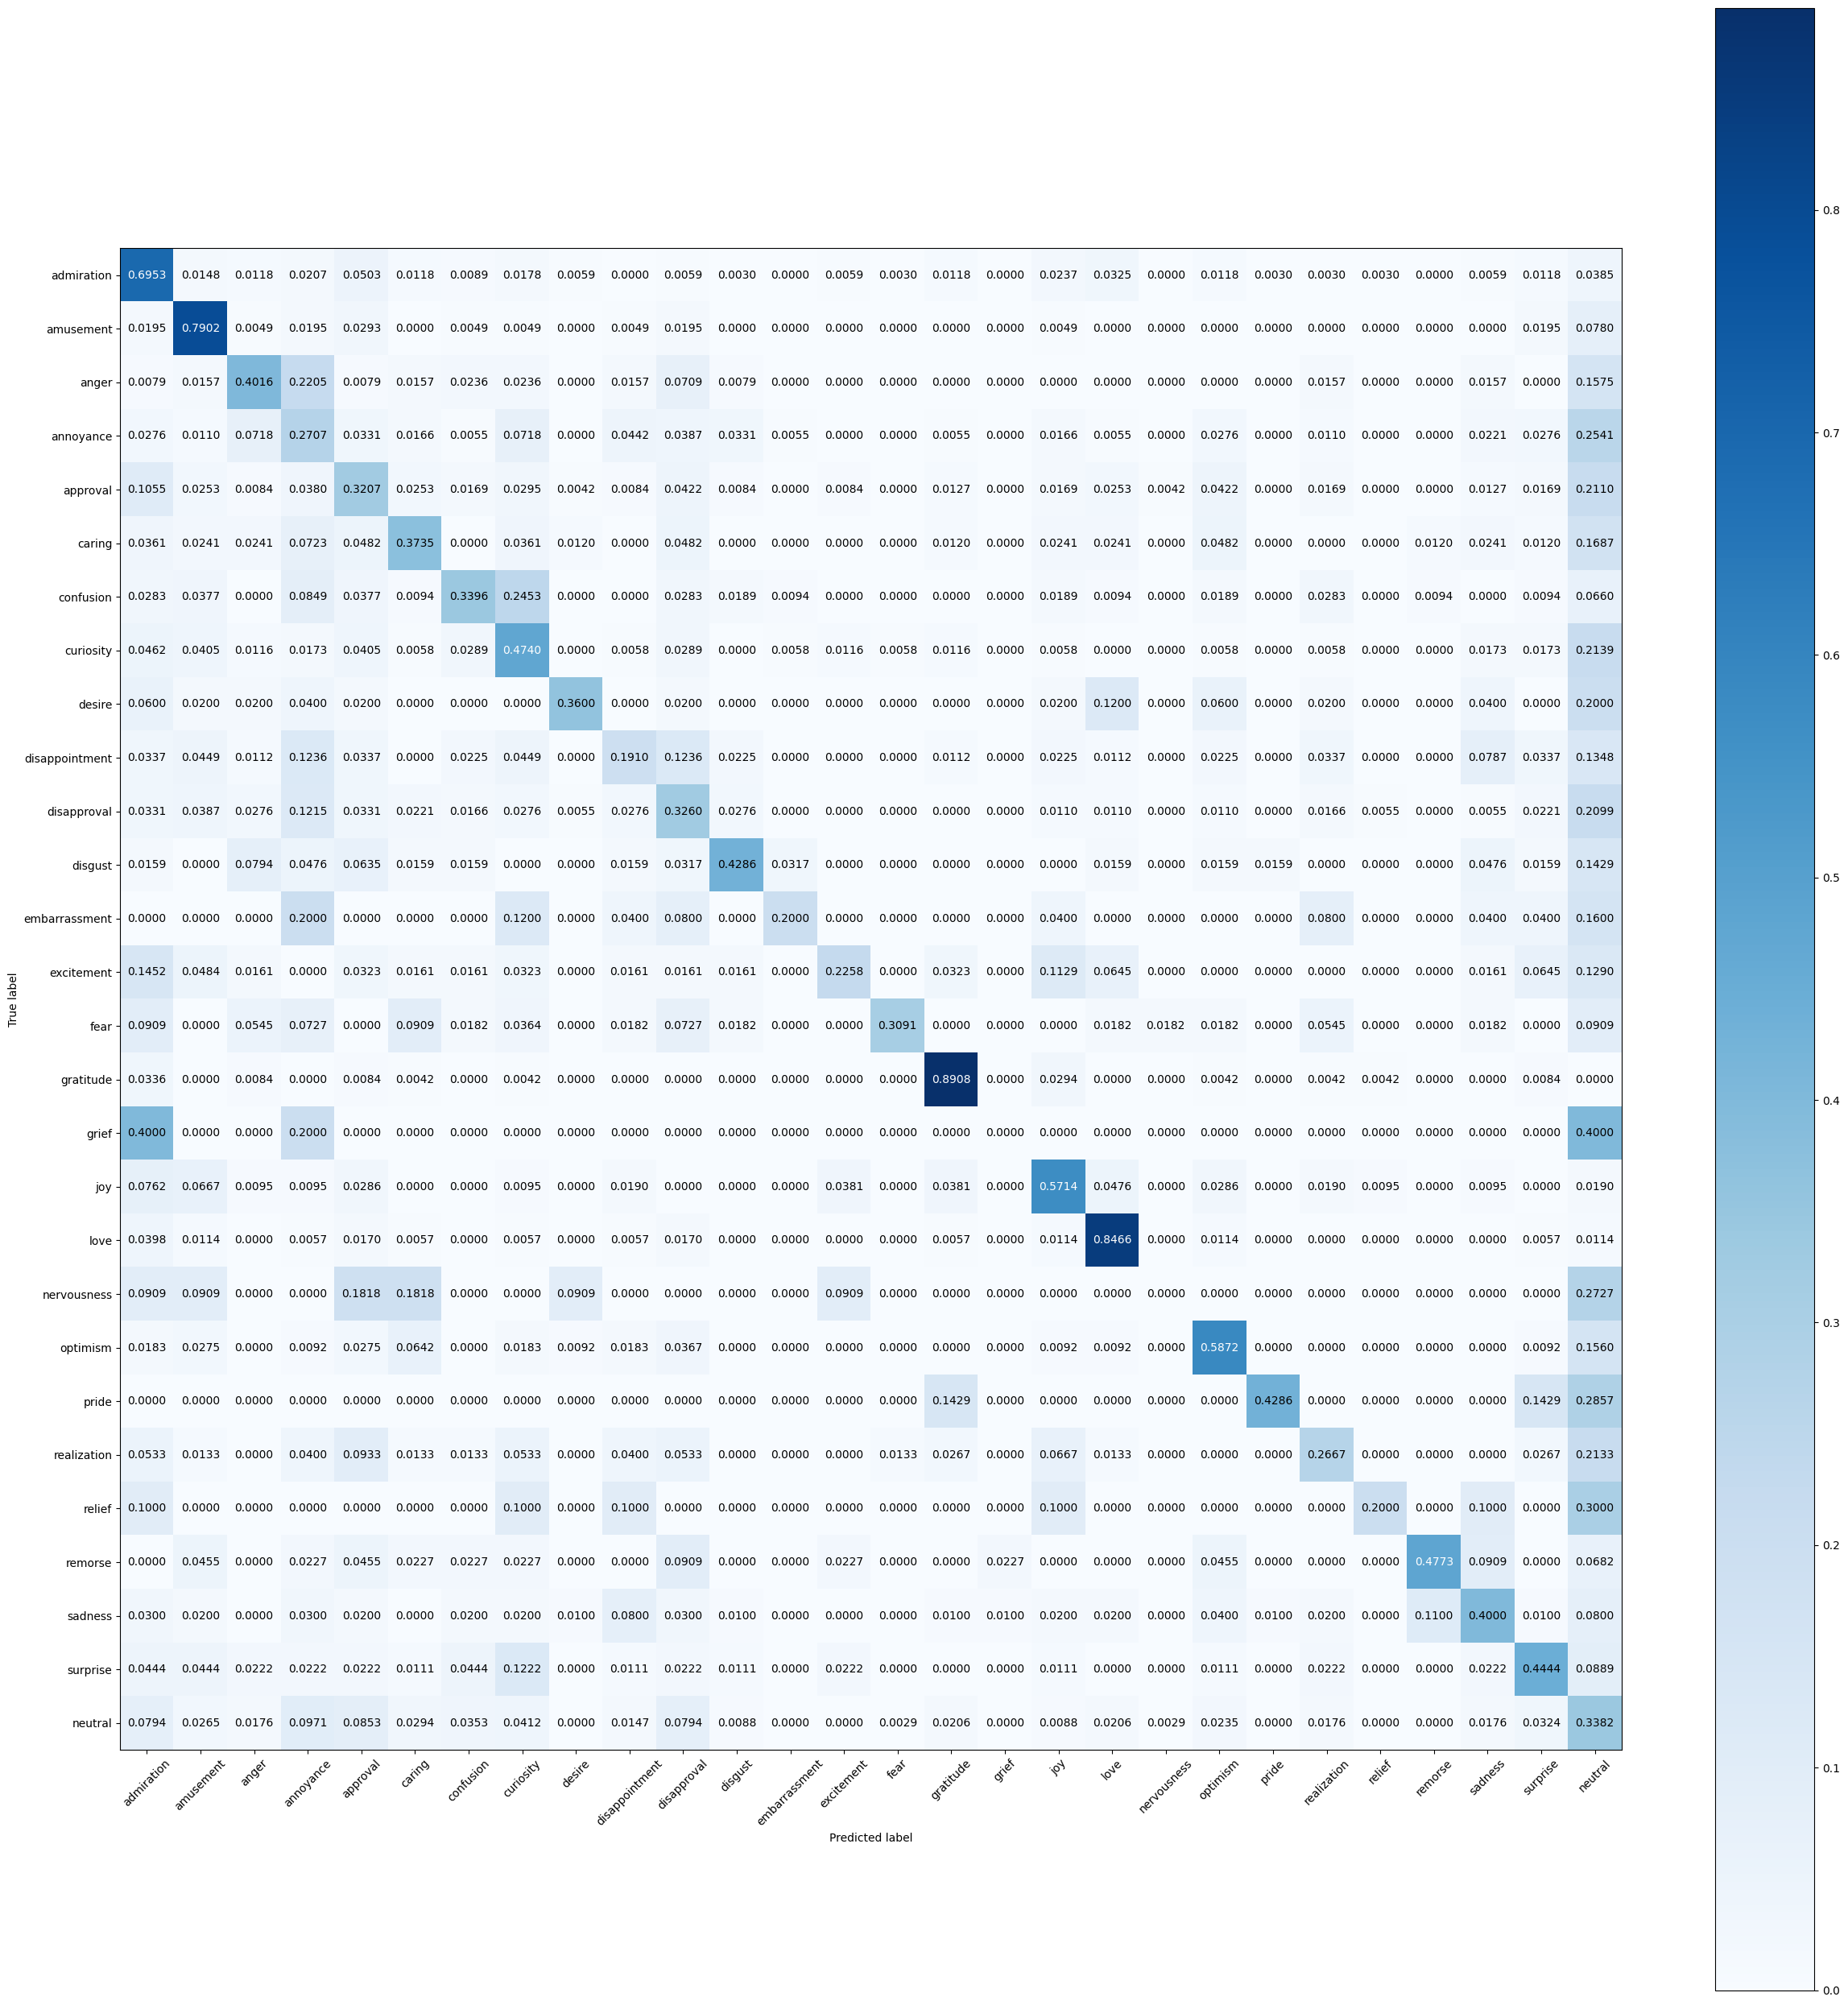

In [14]:
sentiment.plot_conf_mtrx_all(classifier, test_ds, classes)

1/1 [==============================] - 0s 128ms/step


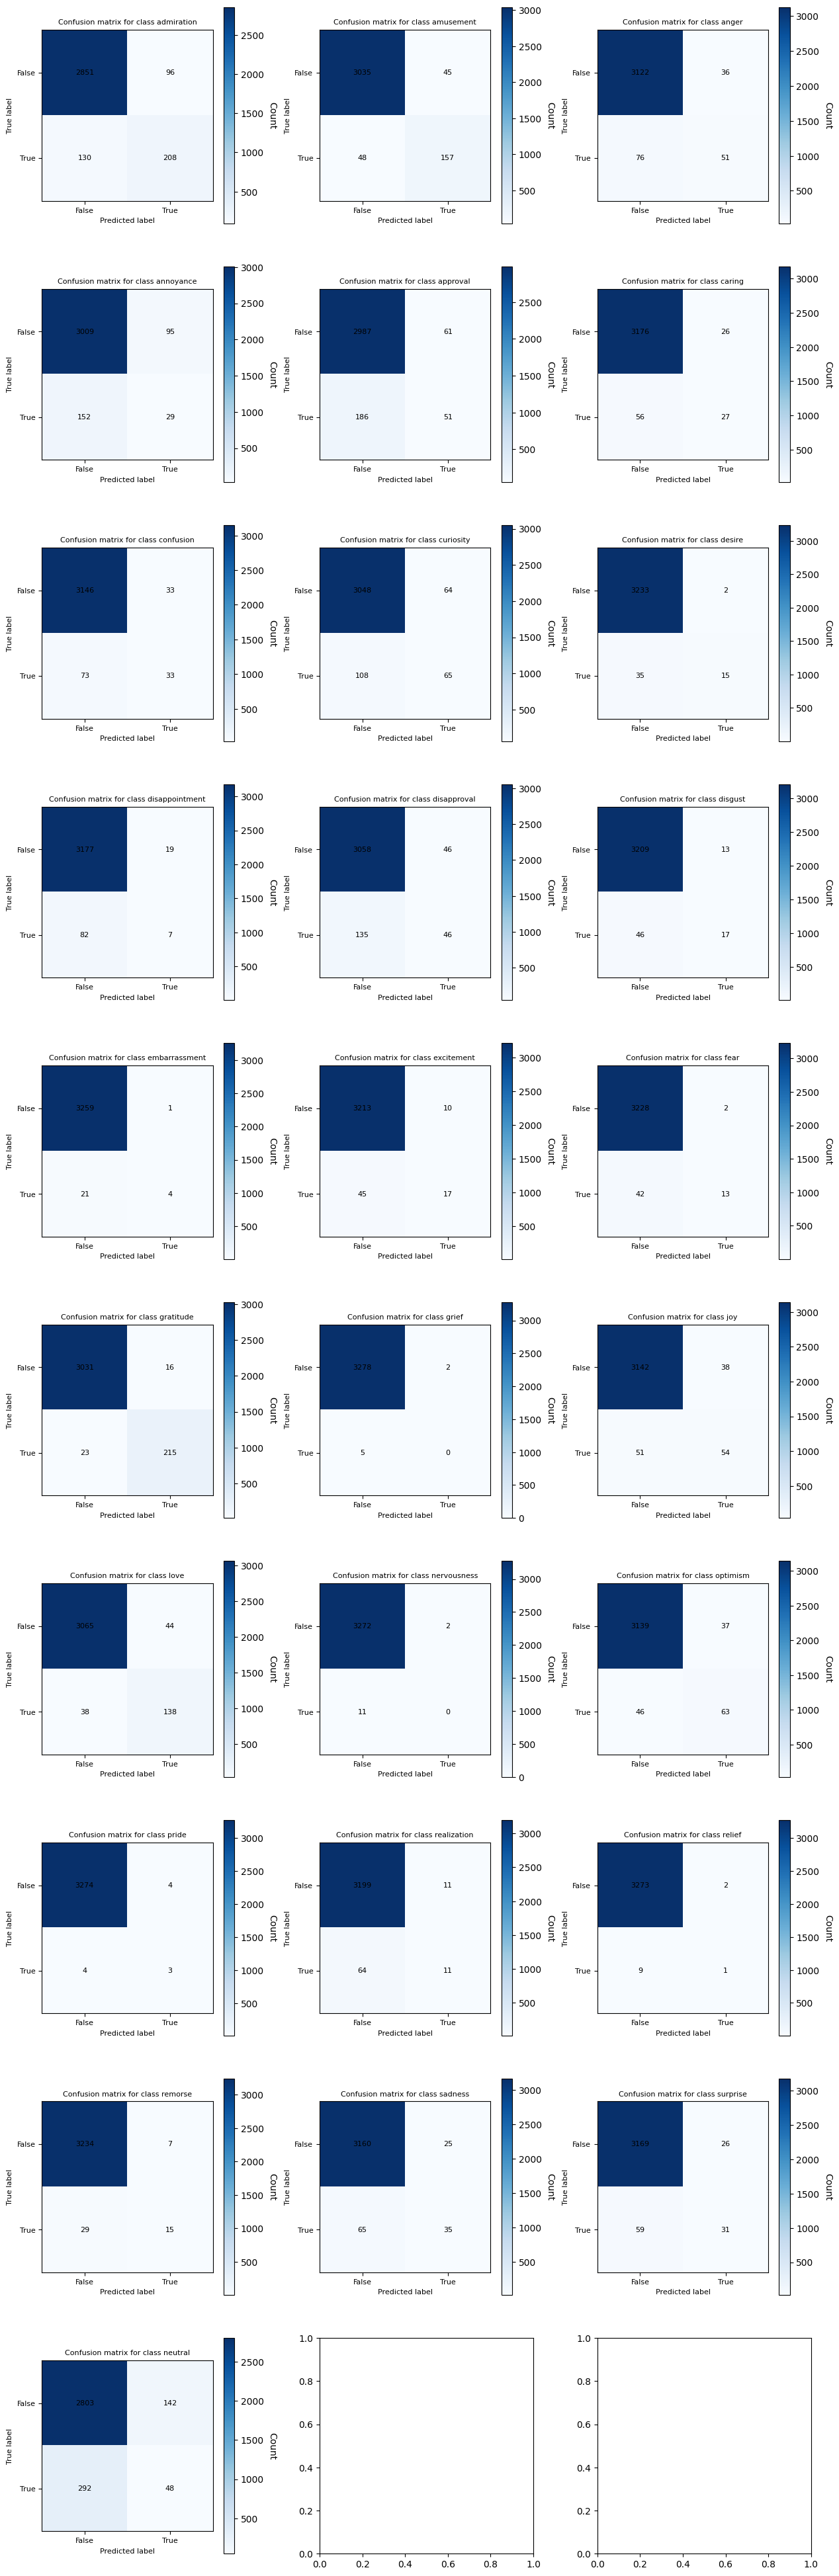

In [15]:
sentiment.plot_conf_mtrx_per_class(classifier, test_ds, classes)

In [16]:
classifier.save('./models/mlp', include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/mlp\assets


## Notes 
